### Run to install necessary pacakages

In [ ]:
# !pip install numpy pandas seaborn matplotlib lightgbm xgboost scikit-learn imbalanced-learn catboost

In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

In [116]:
df = pd.read_csv('data/fraud_oracle_processed.csv')

In [117]:
# Check if there are missing values
df[df.isna().any(axis=1)]

,Unnamed: 0,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,...,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,MonthClaimed,UnusualDeductible,ClaimsPerAgent


In [118]:
df.head()

,Unnamed: 0,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,...,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,MonthClaimed,UnusualDeductible,ClaimsPerAgent
0,0,Dec,5,Wednesday,Honda,Urban,Tuesday,1,0,21,...,2,3,1994,Liability,False,True,False,1,0,15179
1,1,Jan,3,Wednesday,Honda,Urban,Monday,4,1,34,...,0,1,1994,Collision,False,True,False,1,0,15179
2,2,Oct,5,Friday,Honda,Urban,Thursday,2,1,47,...,0,1,1994,Collision,True,False,False,11,0,15179
3,3,Jun,2,Saturday,Toyota,Rural,Friday,1,1,65,...,0,1,1994,Liability,True,False,False,7,0,15179
4,4,Jan,5,Monday,Honda,Urban,Tuesday,2,0,27,...,0,1,1994,Collision,False,True,False,2,0,15179


# **Data cleaning**


In [119]:
# Remove index column
df = df.iloc[:, 1:]

In [120]:
# Remove one row with DayOfWeekClaimed = 0 and MonthClaimed = 0
df = df.loc[~((df['DayOfWeekClaimed'] == '0') | (df['MonthClaimed'] == '0'))]

In [ ]:
# Reorder the columns such that PolicyNumber is first
cols = df.columns.tolist()        
cols.remove('PolicyNumber')       
df = df[['PolicyNumber'] + cols]     
print("Columns:")
for col in cols:
    print(f"• {col}")  

Columns:
• Month
• WeekOfMonth
• DayOfWeek
• Make
• AccidentArea
• DayOfWeekClaimed
• WeekOfMonthClaimed
• Sex
• Age
• Fault
• PolicyType
• VehicleCategory
• VehiclePrice
• FraudFound_P
• RepNumber
• Deductible
• DriverRating
• Days_Policy_Accident
• Days_Policy_Claim
• PastNumberOfClaims
• AgeOfVehicle
• AgeOfPolicyHolder
• PoliceReportFiled
• WitnessPresent
• AgentType
• NumberOfSuppliments
• AddressChange_Claim
• NumberOfCars
• Year
• BasePolicy
• MaritalStatus_Married
• MaritalStatus_Single
• MaritalStatus_Widow
• MonthClaimed
• UnusualDeductible
• ClaimsPerAgent


### Numerical Mapping

In [122]:
# Convert dummy variables to a single MaritalStatus column
df['MaritalStatus'] = df.filter(regex = '^MaritalStatus_').idxmax(axis = 1)
df['MaritalStatus'] = df['MaritalStatus'].str.replace('MaritalStatus_', '')
df.drop(['MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow'], axis = 1, inplace = True)

In [123]:
# Mappings for numerical df

month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

day_mapping = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
}

area_mapping = {
    'Rural': 0, 'Urban': 1
}

fault_mapping = {
    'Policy Holder': 0, 'Third Party': 1
}

vtype_mapping = {
    'Sedan': 1, 'Sport': 2, 'Utility': 3
}

basepol_mapping = {
    'Collision': 1, 'Liability': 2, 'All Perils': 3
}

ptype_mapping = {}
for vtype, v_val in vtype_mapping.items():
    for basepol, bp_val in basepol_mapping.items():
        key = f'{vtype} - {basepol}'
        ptype_mapping[key] = v_val * 10 + bp_val

mstatus_mapping = {
    'Single': 0, 'Married': 1, 'Widow': 2
}

extra_mappings = {
    'Month': month_mapping,
    'DayOfWeek': day_mapping,
    'DayOfWeekClaimed': day_mapping,
    'AccidentArea': area_mapping,
    'Fault': fault_mapping,
    'VehicleCategory': vtype_mapping,
    'BasePolicy': basepol_mapping,
    'PolicyType': ptype_mapping,
    'MaritalStatus': mstatus_mapping
}

In [ ]:
# Convert categorical variables to numerical in numeric df
numeric_df = df.copy()
for col, mapping in extra_mappings.items():
    numeric_df[col] = numeric_df[col].map(mapping)

In [125]:
# Remove Make(car brand) column as VehiclePrice provides more/same value as car brand and car brand is categorical
numeric_df.drop(['Make'], axis = 1, inplace = True)

In [126]:
# Reordering columns for easier visualization
cols = numeric_df.columns.tolist()         
cols.remove("MonthClaimed")   
cols.remove("WeekOfMonthClaimed")
idx = cols.index("DayOfWeekClaimed")
cols.insert(idx, "WeekOfMonthClaimed") 
cols.insert(idx, "MonthClaimed") 
numeric_df = numeric_df[cols]

### Cleaning of data with Age = 0

In [127]:
import lightgbm as lgb

# use a LightGBM regression model to predict a reasonable Age value for those rows.
age_outliers = (numeric_df['Age'] == 0)
train_df_age = numeric_df[~age_outliers].copy()
X_train_age = train_df_age.drop(columns = ['Age'])
y_train_age = train_df_age['Age']
lgb_train = lgb.Dataset(X_train_age, label = y_train_age)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 123
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
X_outliers_age = numeric_df.loc[age_outliers].drop(columns=['Age'])
numeric_df.loc[age_outliers, 'Age'] = np.rint(gbm.predict(X_outliers_age)).astype(int)

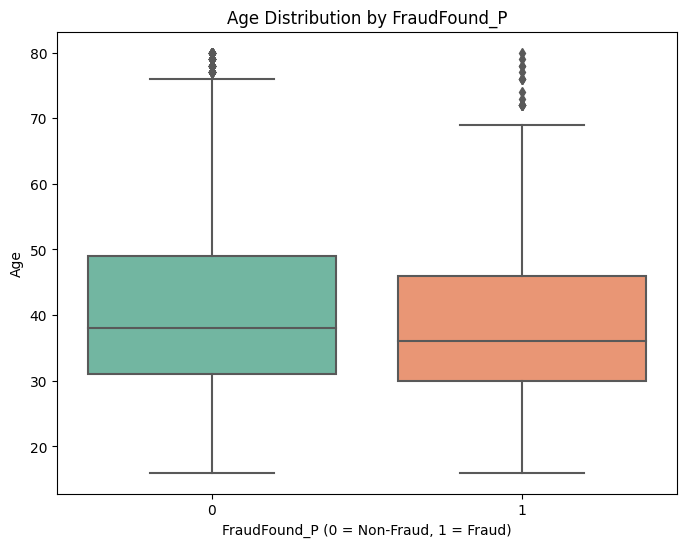

In [128]:
# Distribution of Modified Age
plt.figure(figsize=(8,6))
sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')
plt.title('Age Distribution by FraudFound_P')
plt.xlabel('FraudFound_P (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Age')
plt.savefig("viz/modified_age_dist.png", dpi=300, bbox_inches='tight')
plt.show()

# **Hypothesis Testing**

In [129]:
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = UserWarning)

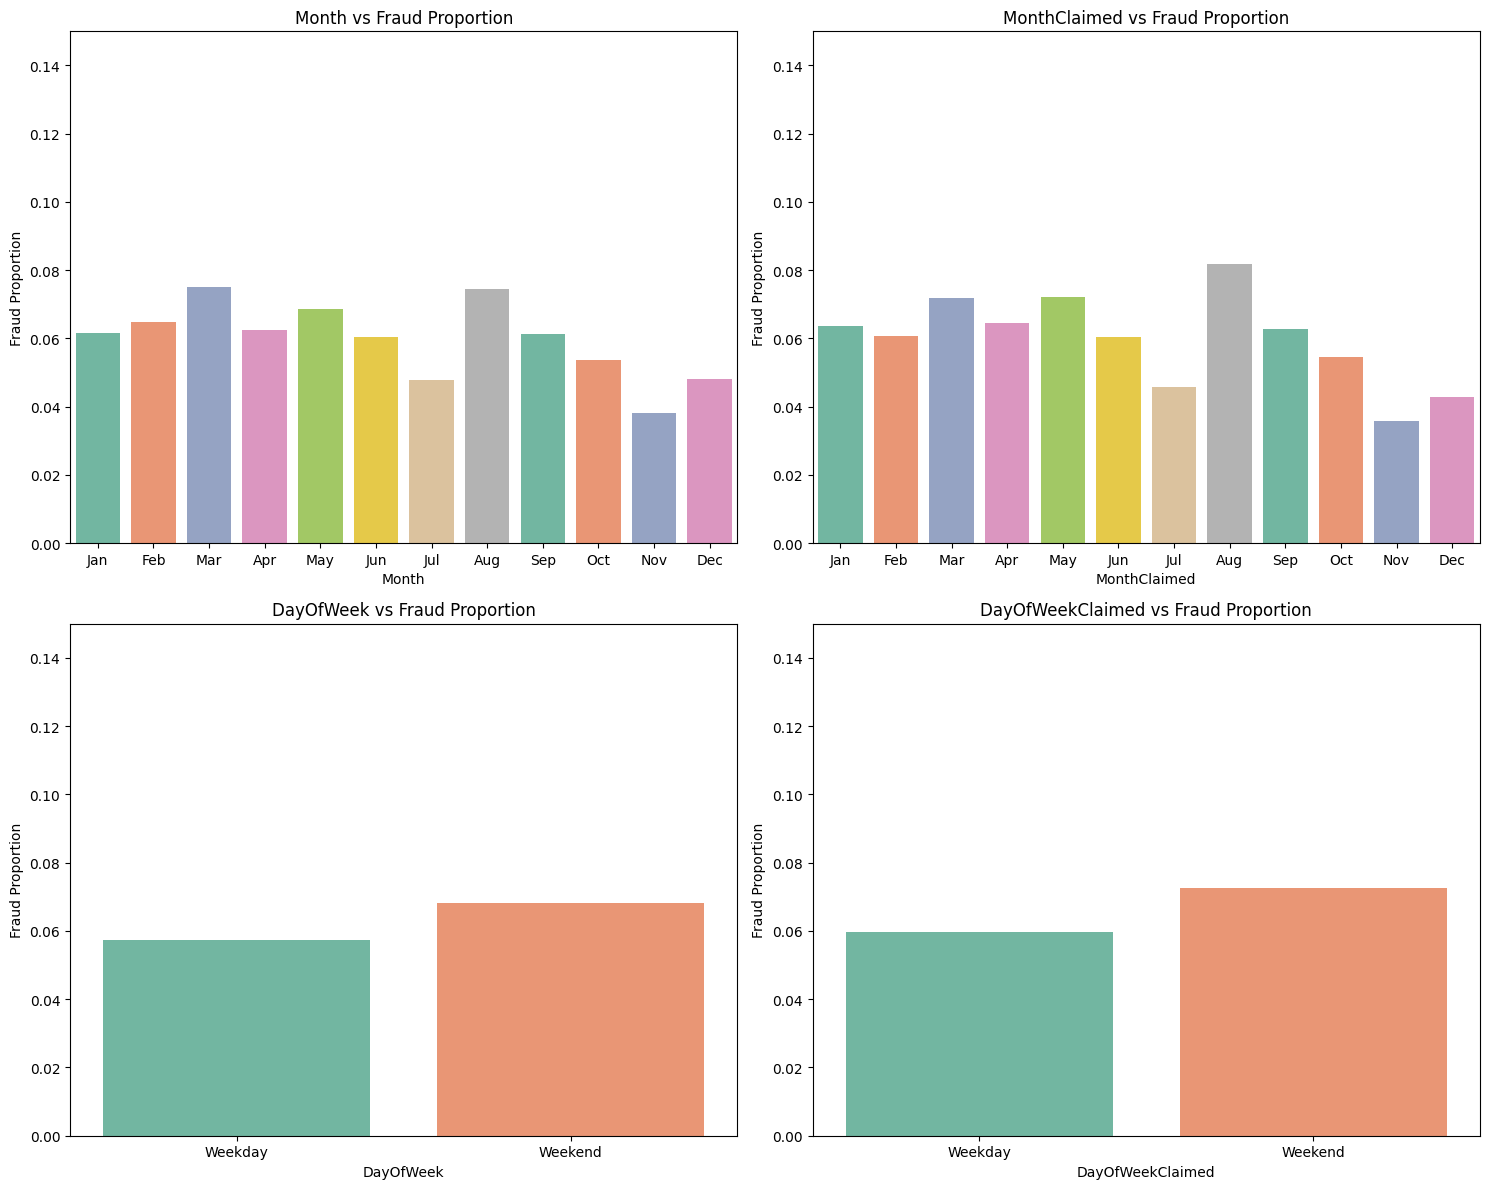

In [ ]:
# Hypothesis 1: Temporal Variables
## Fraudulent claims are more likely to occur during specific periods, such as Mondays or end-of-year.

temporal_vars = ['Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed']

# Create a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


day_mapping = {
    1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday', 5: 'Weekday', 6: 'Weekend', 7: 'Weekend'
}
day_order = ['Weekday', 'Weekend']

temp_df = numeric_df.copy() 
order = None
    
for i, var in enumerate(temporal_vars):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'Month' or var == 'MonthClaimed':
        temp_df[var] = temp_df[var].replace(month_mapping)
    else:
        temp_df[var] = temp_df[var].replace(day_mapping)
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    if var == 'Month' or var == 'MonthClaimed':
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax, order = month_order)
    else:
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax, order = day_order)
    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion') 
    ax.set_ylim(0, 0.15)
    
plt.tight_layout()
plt.savefig("viz/hypothesis_1_results.png", dpi=300, bbox_inches='tight')
plt.show()

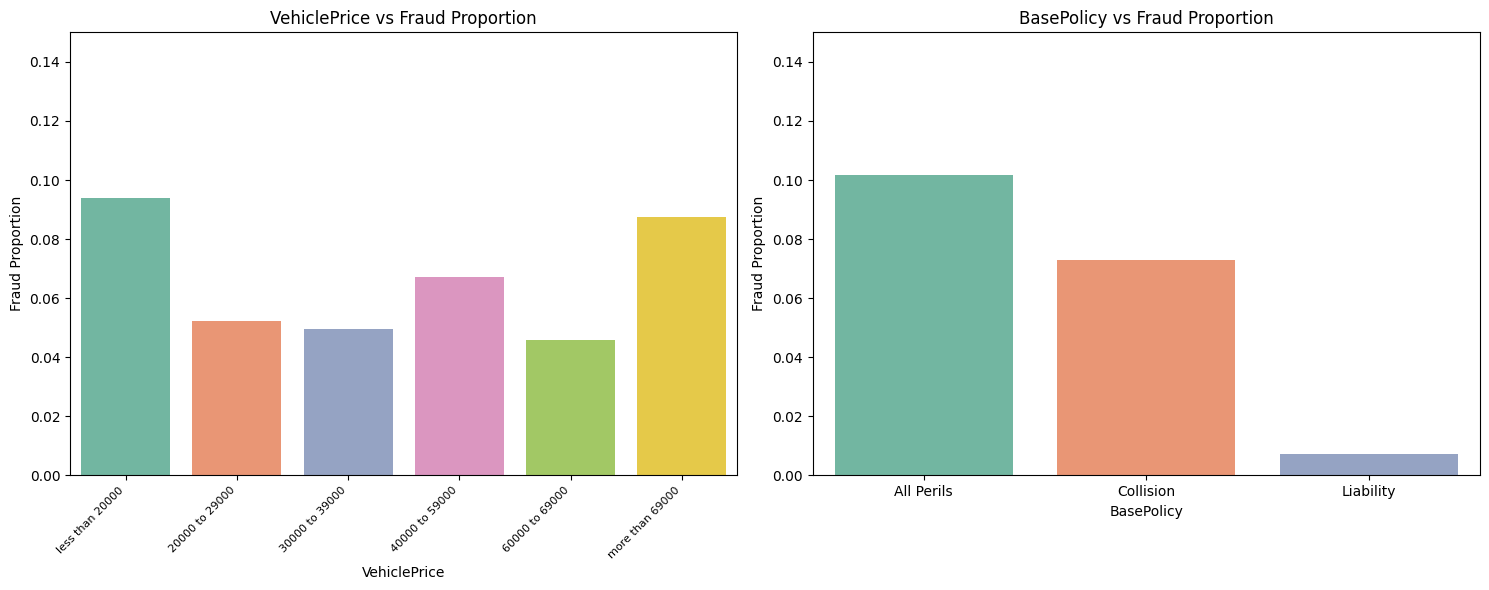

In [ ]:
# Hypothesis 2: Policy and Vehicle Information
## High-value vehicles with minimal coverage (e.g., Collision only) are more susceptible to fraudulent claims

polval_vars = ['VehiclePrice', 'BasePolicy']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None
vehicle_price_mapping = {0: 'less than 20000', 1: '20000 to 29000', 2: '30000 to 39000', 
                         3: '40000 to 59000', 4: '60000 to 69000', 5: 'more than 69000'}
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', 
                       '40000 to 59000', '60000 to 69000', 'more than 69000']
    
for i, var in enumerate(polval_vars):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'VehiclePrice':
        temp_df[var] = temp_df[var].replace(vehicle_price_mapping)
        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    if var == 'VehiclePrice':
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax, order = vehicle_price_order)
    else:
        sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  
    ax.set_ylim(0, 0.15)  
    if var == 'VehiclePrice':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("viz/hypothesis_2_results.png", dpi=300, bbox_inches='tight')
plt.show()

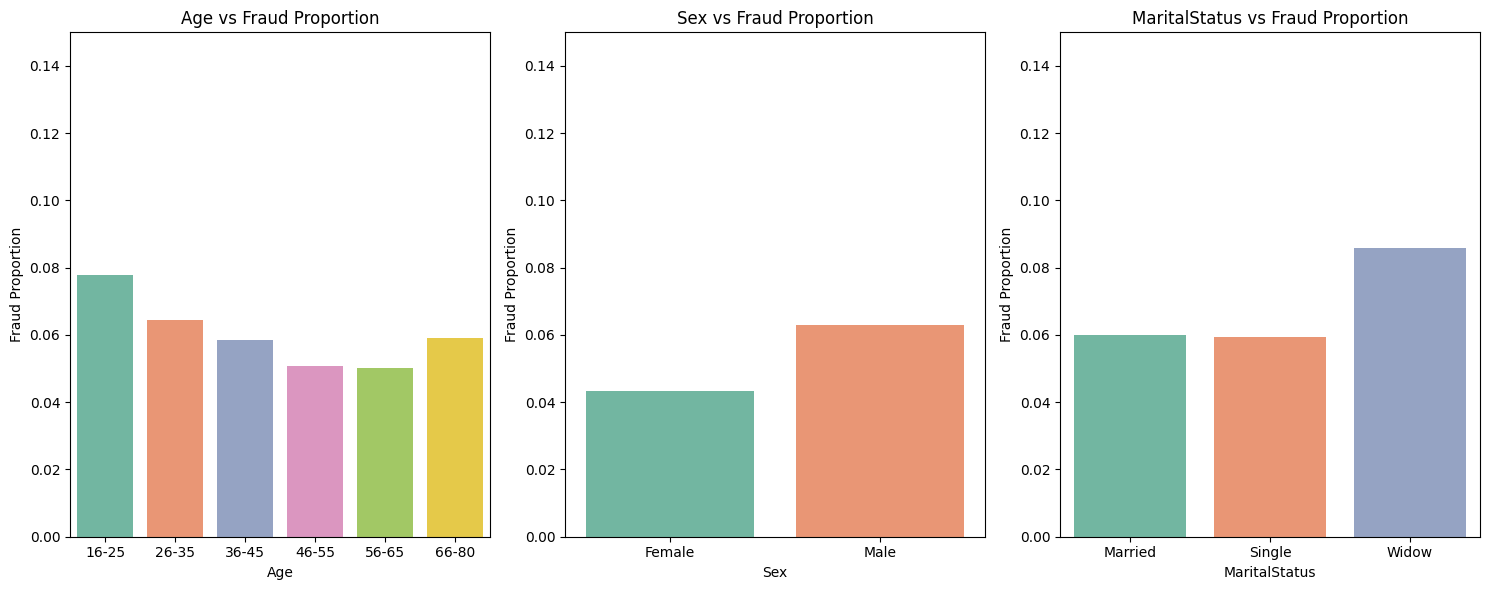

In [ ]:
# Hypothesis 3: Customer Demographics
## Young male policyholders who are single are more likely to commit fraud.

customer_demo = ['Age', 'Sex', 'MaritalStatus']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()

temp_df = numeric_df.copy() 
order = None

sex_mapping = {
    0: 'Female', 1: 'Male'
}
mstatus_mapping = {
    0: 'Single', 1: 'Married', 2:'Widow'
}

    
for i, var in enumerate(customer_demo):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'Sex':
        temp_df[var] = temp_df[var].replace(sex_mapping)
    elif var == 'Age':
        bins = [16, 26, 36, 46, 56, 66, 81]
        labels_age = ["16-25", "26-35", "36-45", "46-55", "56-65", "66-80"]
        temp_df[var] = pd.cut(temp_df[var], bins=bins, labels=labels_age, right=False)
    else:
        temp_df[var] = temp_df[var].replace(mstatus_mapping)
        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')  
    ax.set_ylim(0, 0.15)  

plt.tight_layout()
plt.savefig("viz/hypothesis_3_results.png", dpi=300, bbox_inches='tight')
plt.show()

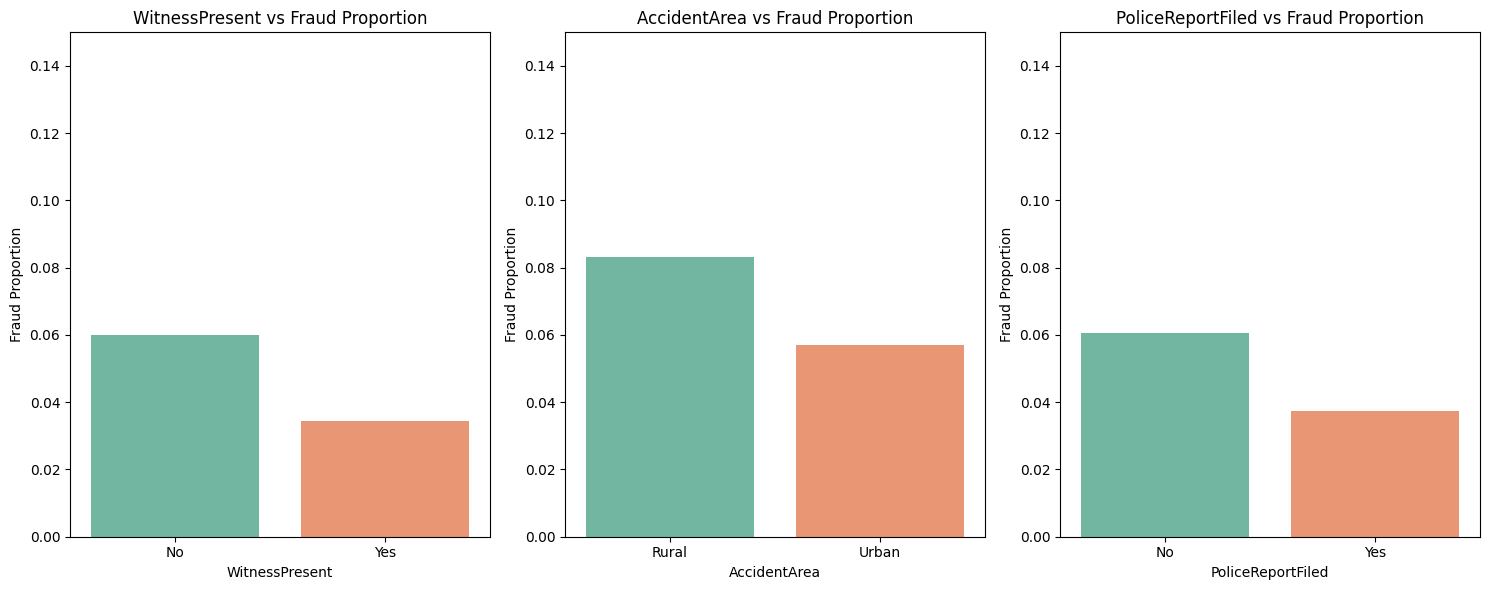

In [ ]:
# Hypothesis 4: Accident Circumstances
## Accidents in urban areas with no witnesses are more likely to result in fraudulent claims.

accident_circumstance = ['WitnessPresent', 'AccidentArea', 'PoliceReportFiled']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None

binary_mapping = {
    0: 'No', 1: 'Yes'
}
    
for i, var in enumerate(accident_circumstance):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'WitnessPresent' or 'PoliceReportFiled':
        temp_df[var] = temp_df[var].replace(binary_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion') 
    ax.set_ylim(0, 0.15)  

plt.tight_layout()
plt.savefig("viz/hypothesis_4_results.png", dpi=300, bbox_inches='tight')
plt.show()

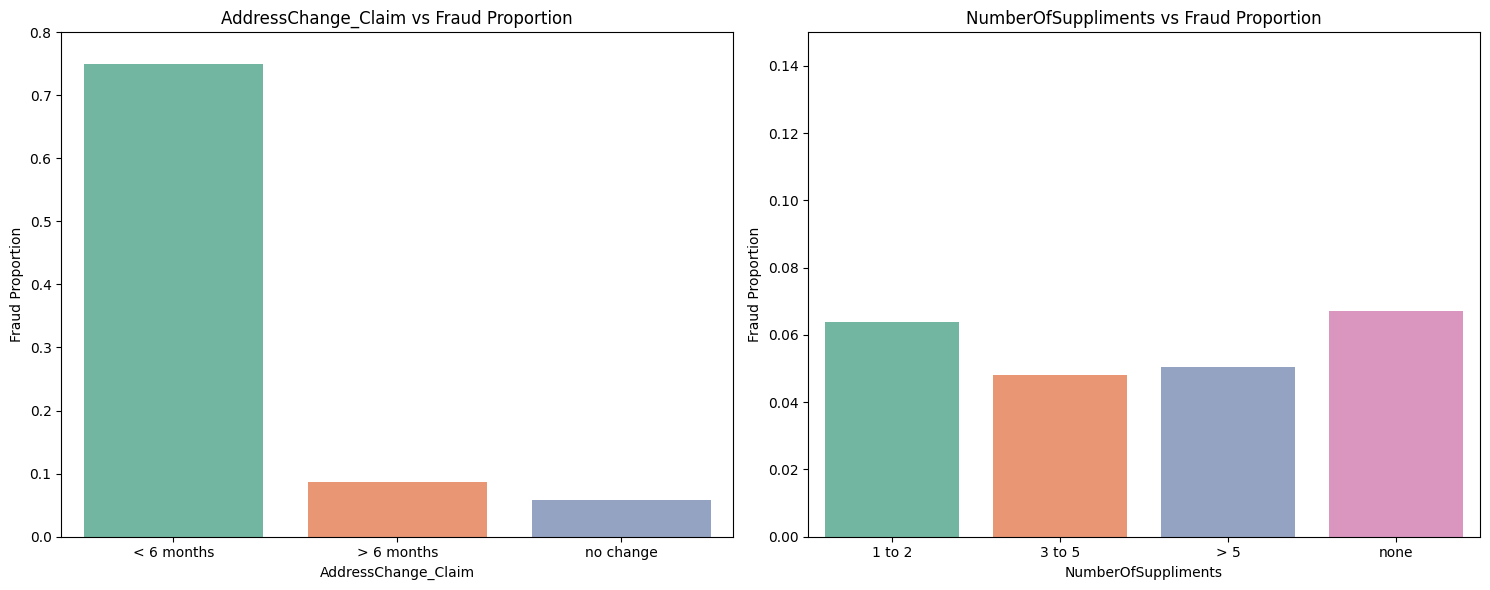

In [ ]:
# Hypothesis 5: Claim Filing Process
## Irregular filing or document changes (e.g., address changes, high number of supplements) are associated with fraud.

filing_process = ['AddressChange_Claim', 'NumberOfSuppliments']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None

supp_mapping = {
    0: 'none', 1: '1 to 2', 3: '3 to 5', 5: '> 5'
}
ac_mapping = {
    0: 'no change', 1: '< 6 months', 2: '> 6 months', 3: '> 6 months', 4: '> 6 months'
}

    
for i, var in enumerate(filing_process):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'NumberOfSuppliments':
        temp_df[var] = temp_df[var].replace(supp_mapping)
    else:
        temp_df[var] = temp_df[var].replace(ac_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion')
    if var == 'NumberOfSuppliments':
        ax.set_ylim(0, 0.15)
    else:
        ax.set_ylim(0, 0.8)

plt.tight_layout()
plt.savefig("viz/hypothesis_5_results.png", dpi=300, bbox_inches='tight')
plt.show()

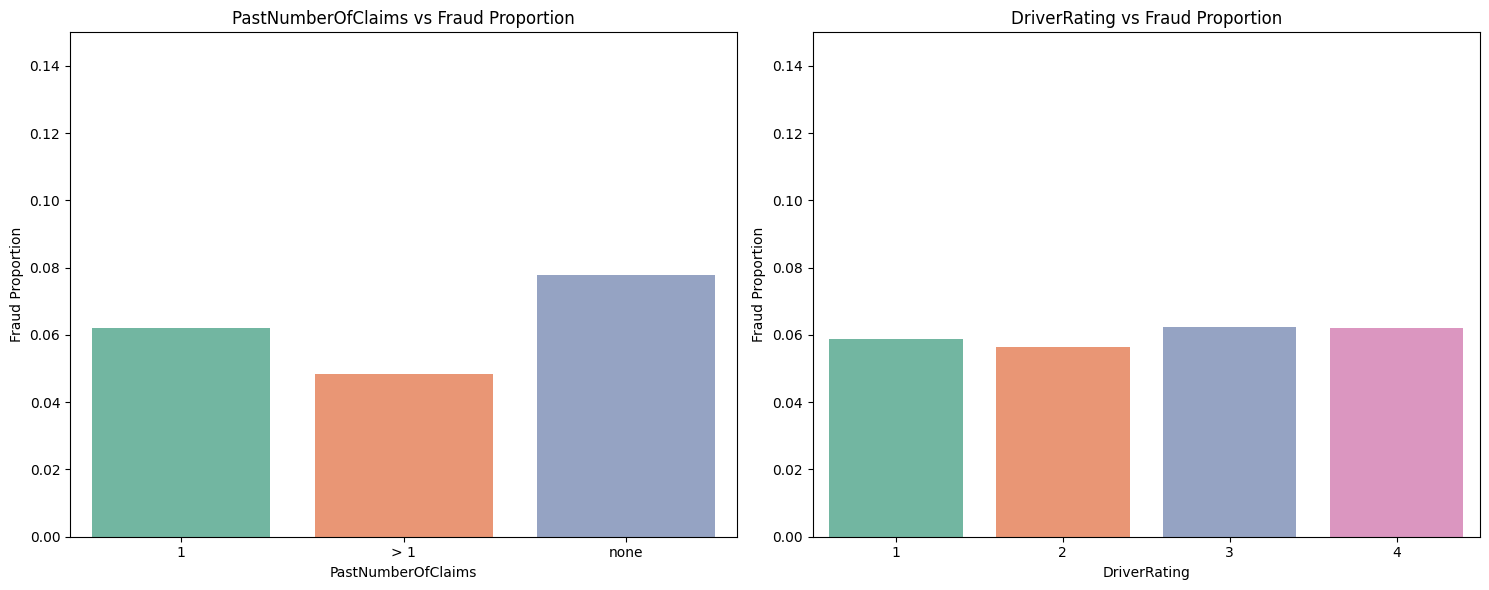

In [ ]:
# Hypothesis 6: Historical Behaviour
## Multiple past claims and low driver ratings correlate strongly with higher fraud rates.

hist_behaviour = ['PastNumberOfClaims', 'DriverRating']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = df.copy() 
order = None

pnoc_mapping = {
    0: 'none', 1: 1, 2: '> 1', 3: '> 1'
}
    
for i, var in enumerate(hist_behaviour):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    if var == 'PastNumberOfClaims':
        temp_df[var] = temp_df[var].replace(pnoc_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion') 
    ax.set_ylim(0, 0.15) 

plt.tight_layout()
plt.savefig("viz/hypothesis_6_results.png", dpi=300, bbox_inches='tight')
plt.show()

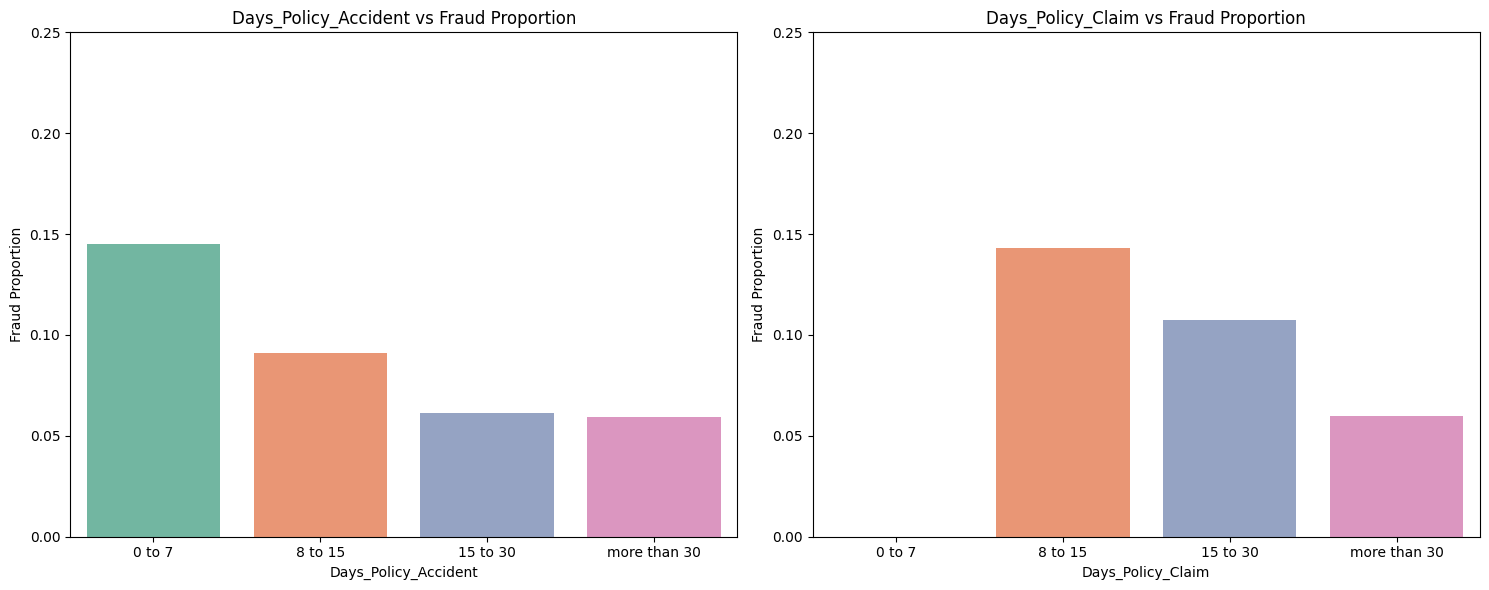

In [ ]:
# Hypothesis 7: Time Gaps and Delays
## Extremely short or long periods between 
## 1) policy issuance and accident 
## 2) policy issuance and claim made
## are red flags for fraudulent claims.

delays = ['Days_Policy_Accident', 'Days_Policy_Claim']

# Create a 1x2 grid for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

temp_df = numeric_df.copy() 
order = None

dp_mapping = {
    0: '0 to 7', 1: '0 to 7', 2: '8 to 15', 3: '15 to 30', 4: "more than 30"
}
dp_order = ['0 to 7', '8 to 15', '15 to 30', 'more than 30']
    
for i, var in enumerate(delays):
    # Group data to compute the proportion of fraud (FraudFound_P == 1)
    
    temp_df[var] = temp_df[var].replace(dp_mapping)

        
    fraud_prop = temp_df.groupby(var)['FraudFound_P'].mean().reset_index()
    
    ax = axs[i]
    sns.barplot(x=var, y='FraudFound_P', data=fraud_prop, palette='Set2', ax=ax, order = dp_order)

    
    # Remove bar outlines by setting linewidth to 0 for each patch
    for patch in ax.patches:
        patch.set_linewidth(0)
    
    ax.set_title(f'{var} vs Fraud Proportion')
    ax.set_xlabel(var)
    ax.set_ylabel('Fraud Proportion') 
    ax.set_ylim(0, 0.25) 

plt.tight_layout()
plt.savefig("viz/hypothesis_7_results.png", dpi=300, bbox_inches='tight')
plt.show()

# **Feature Engineering (New features)**

In [ ]:
# Feature 1: Price-to-Age Ratio (to flag potentially overinsured vehicles)
numeric_df['PriceToAgeRatio'] = np.log1p((numeric_df['VehiclePrice'] + 1) / (numeric_df['AgeOfVehicle'] + 1))
cutoff = numeric_df['PriceToAgeRatio'].quantile(0.95)
numeric_df['PriceToAgeRatio_Capped'] = np.where(numeric_df['PriceToAgeRatio'] > cutoff, cutoff, numeric_df['PriceToAgeRatio'])

# Feature 2: High-Risk Vehicle Flag (expensive + frequent claims)
numeric_df['HighRiskVehicleFlag'] = np.where(
    (numeric_df['PriceToAgeRatio'] > cutoff) & (numeric_df['PastNumberOfClaims'] > 1), 
    1, 0
)

numeric_df[['VehiclePrice', 'AgeOfVehicle', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 'PriceToAgeRatio', 'PriceToAgeRatio_Capped', 'HighRiskVehicleFlag']].head()

,VehiclePrice,AgeOfVehicle,PastNumberOfClaims,AgeOfPolicyHolder,PriceToAgeRatio,PriceToAgeRatio_Capped,HighRiskVehicleFlag
0,5,2,0,28,1.098612,0.693147,0
1,5,5,0,33,0.693147,0.693147,0
2,5,6,1,45,0.619039,0.619039,0
3,1,7,1,58,0.223144,0.223144,0
4,5,4,0,33,0.788457,0.693147,0


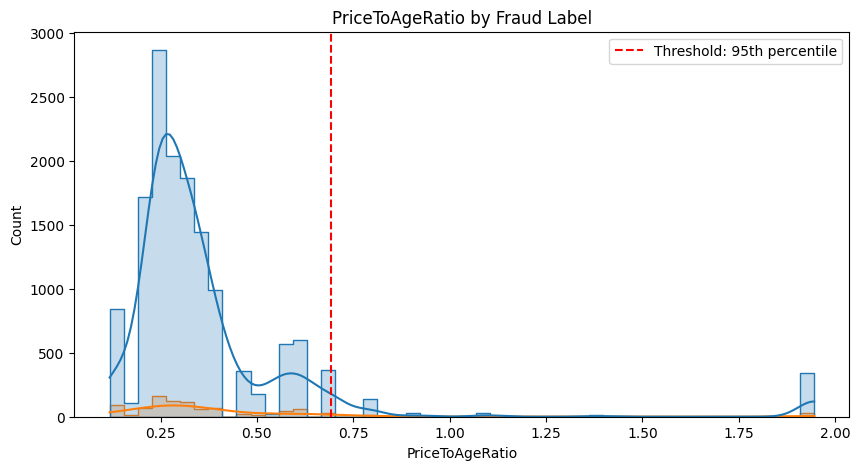

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data=numeric_df, x='PriceToAgeRatio', hue='FraudFound_P', bins=50, kde=True, element='step')
plt.axvline(cutoff, color='red', linestyle='--', label='Threshold: 95th percentile')
plt.title('PriceToAgeRatio by Fraud Label')
plt.xlabel('PriceToAgeRatio')
plt.ylabel('Count')
plt.legend()
plt.savefig("viz/pricetoageratio_dist.png", dpi=300, bbox_inches='tight')
plt.show()

In [139]:
numeric_df['DriverRating'] = numeric_df['DriverRating'].astype(int)

# Feature 3: ClaimAmountRisk where expensive vehicles with low rated drivers might be more prone to fraud
numeric_df['ClaimAmountRisk'] = numeric_df['VehiclePrice'] * numeric_df['DriverRating']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


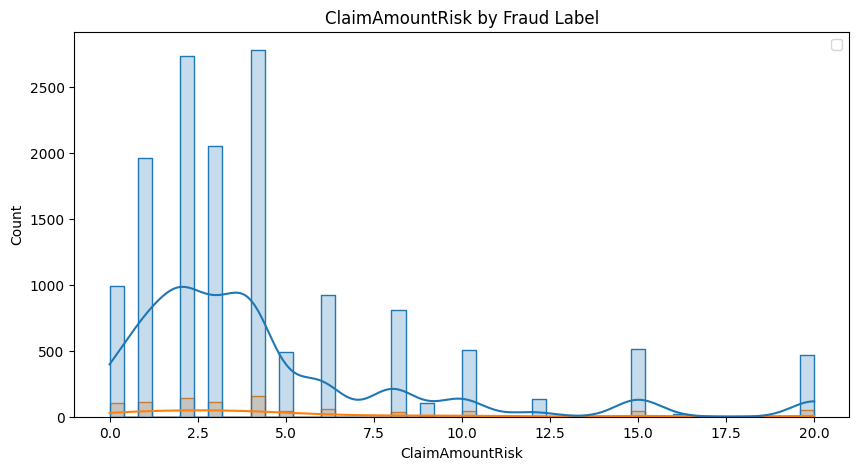

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data=numeric_df, x='ClaimAmountRisk', hue='FraudFound_P', bins=50, kde=True, element='step')
plt.title('ClaimAmountRisk by Fraud Label')
plt.xlabel('ClaimAmountRisk')
plt.ylabel('Count')
plt.legend()
plt.savefig("viz/claimamountrisk_dist.png", dpi=300, bbox_inches='tight')
plt.show()

### Days Between Claim Made and Claim Processed

In [141]:
# Feature 4: Claim Processing Time
# Create a column called ClaimProcessingTime to get the number of days between claim made and processed
# Compute a rough day-of-year approximation for accident and claim dates.
numeric_df['claim_day'] = (numeric_df['Month'] - 1) * 30 + (numeric_df['WeekOfMonth'] - 1) * 7 + numeric_df['DayOfWeek']
numeric_df['processed_day'] = (numeric_df['MonthClaimed'] - 1) * 30 + (numeric_df['WeekOfMonthClaimed'] - 1) * 7 + numeric_df['DayOfWeekClaimed']
numeric_df['ClaimProcessingTime'] = numeric_df['processed_day'] - numeric_df['claim_day'] 
numeric_df['ClaimProcessingTime'] = numeric_df['ClaimProcessingTime'] + 365
numeric_df.drop(['claim_day', 'processed_day'], axis = 1, inplace = True)

print(numeric_df['ClaimProcessingTime'])
numeric_df[numeric_df['ClaimProcessingTime'] > 0]

0          6
1        370
2        373
3        387
4        375
        ... 
15415    369
15416    368
15417    368
15418    375
15419    373
Name: ClaimProcessingTime, Length: 15419, dtype: int64


,PolicyNumber,Month,WeekOfMonth,DayOfWeek,AccidentArea,MonthClaimed,WeekOfMonthClaimed,DayOfWeekClaimed,Sex,Age,...,Year,BasePolicy,UnusualDeductible,ClaimsPerAgent,MaritalStatus,PriceToAgeRatio,PriceToAgeRatio_Capped,HighRiskVehicleFlag,ClaimAmountRisk,ClaimProcessingTime
0,1,12,5,3,1,1,1,2,0,21,...,1994,2,0,15179,0,1.098612,0.693147,0,5,6
1,2,1,3,3,1,1,4,1,1,34,...,1994,1,0,15179,0,0.693147,0.693147,0,20,370
2,3,10,5,5,1,11,2,4,1,47,...,1994,1,0,15179,1,0.619039,0.619039,0,15,373
3,4,6,2,6,0,7,1,5,1,65,...,1994,2,0,15179,1,0.223144,0.223144,0,2,387
4,5,1,5,1,1,2,2,2,0,27,...,1994,1,0,15179,0,0.788457,0.693147,0,5,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,15416,11,4,5,1,11,5,2,1,35,...,1996,1,0,15179,1,0.287682,0.287682,0,4,369
15416,15417,11,5,4,1,12,1,5,1,30,...,1996,2,0,15179,1,0.405465,0.405465,0,6,368
15417,15418,11,5,4,0,12,1,5,1,24,...,1996,1,0,15179,0,0.336472,0.336472,0,4,368
15418,15419,12,1,1,1,12,2,4,0,34,...,1996,3,0,15179,1,0.693147,0.693147,0,4,375


From our exploration of the data, we realise that the max difference in claim made date and claim processed date is 363, so we add 365 days to remove all the negative data. BIG ASSUMPTION

### External Validation Flag

In [142]:
#Feature 5: Absence of External Validation
numeric_df['AbsenceOfExternalValidation'] = np.where(
    (numeric_df['WitnessPresent'] == 0) & (numeric_df['PoliceReportFiled'] == 0),
    1, 0
)

### Address Change Claim within 6 months flag

In [143]:
#Feature 6: Address Change Within 6 months
numeric_df['AddressChangeWithinSixMonths'] = np.where(
    numeric_df['AddressChange_Claim'] == 1,
    1, 0
)

### Outlier Detection Score

Training autoencoder...
Epoch 1: Loss = 5992499.5000
Epoch 2: Loss = 5986239.5000
Epoch 3: Loss = 5980259.5000
Epoch 4: Loss = 5974559.0000
Epoch 5: Loss = 5969124.0000
Epoch 6: Loss = 5963944.0000
Epoch 7: Loss = 5959005.5000
Epoch 8: Loss = 5954303.5000
Epoch 9: Loss = 5949830.0000
Epoch 10: Loss = 5945578.5000
Epoch 11: Loss = 5941540.0000
Epoch 12: Loss = 5937705.0000
Epoch 13: Loss = 5934080.5000
Epoch 14: Loss = 5930717.0000
Epoch 15: Loss = 5927515.5000
Epoch 16: Loss = 5924457.0000
Epoch 17: Loss = 5921527.5000
Epoch 18: Loss = 5918955.0000
Epoch 19: Loss = 5916600.5000
Epoch 20: Loss = 5914292.5000
Epoch 21: Loss = 5912013.0000
Epoch 22: Loss = 5909746.5000
Epoch 23: Loss = 5907487.0000
Epoch 24: Loss = 5905500.5000
Epoch 25: Loss = 5903687.0000
Epoch 26: Loss = 5901859.0000
Epoch 27: Loss = 5900081.5000
Epoch 28: Loss = 5898164.5000
Epoch 29: Loss = 5896087.5000
Epoch 30: Loss = 5893847.0000
Epoch 31: Loss = 5891518.5000
Epoch 32: Loss = 5889122.5000
Epoch 33: Loss = 5886587.

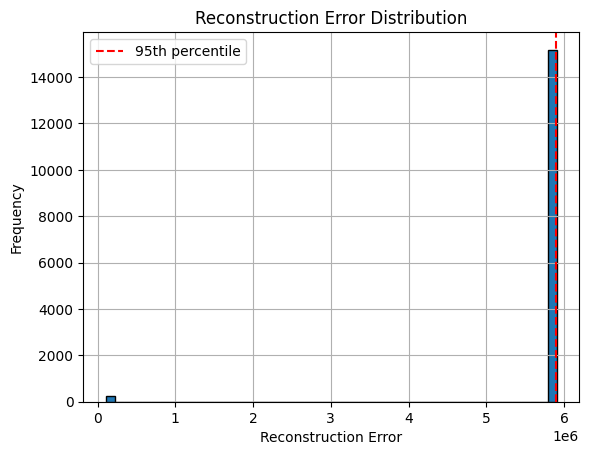

Top outliers detected: 771


In [144]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Step 1: Copy and clean data
df = numeric_df.copy(deep=True)
df_clean = df.drop(columns=["PolicyNumber", "FraudFound_P"])  # Drop ID and target columns

# Step 2: Convert to Torch Tensor (skip scaling for binary/categorical-heavy data)
X_tensor = torch.tensor(df_clean.values, dtype=torch.float32)

# Step 3: Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Step 4: Train Autoencoder
input_dim = df_clean.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

print("Training autoencoder...")
for epoch in range(50):  
    optimizer.zero_grad()
    outputs = autoencoder(X_tensor)
    loss = criterion(outputs, X_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Step 5: Compute reconstruction error
with torch.no_grad():
    reconstructed = autoencoder(X_tensor)
    reconstruction_error = torch.mean((X_tensor - reconstructed) ** 2, axis=1).numpy()

# Step 6: Flag top 5% as outliers
threshold = np.percentile(reconstruction_error, 95)
is_outlier = (reconstruction_error > threshold).astype(int)

# Step 7: Concat scores and flags back into numeric_df
numeric_df["ReconstructionError"] = reconstruction_error
numeric_df["IsOutlier"] = is_outlier

# Step 8: Visualize reconstruction error
plt.hist(reconstruction_error, bins=50, edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label='95th percentile')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Preview outliers
outliers = numeric_df[numeric_df["IsOutlier"] == 1]
print(f"Top outliers detected: {len(outliers)}")



In [ ]:
# Now all values are numeric and ready for Feature Selection and future modelling
all_numeric = all(np.issubdtype(dtype, np.number) for dtype in numeric_df.dtypes)
print(all_numeric)

True


## Overview of value counts

In [146]:
for col in numeric_df.columns:
    print(f"Value counts for {col}:")
    print(numeric_df[col].value_counts())
    print("\n")

Value counts for PolicyNumber:
PolicyNumber
1        1
10361    1
10273    1
10274    1
10275    1
        ..
5146     1
5147     1
5148     1
5149     1
15420    1
Name: count, Length: 15419, dtype: int64


Value counts for Month:
Month
1     1411
5     1367
3     1360
6     1321
10    1305
12    1285
4     1280
2     1266
7     1256
9     1240
11    1201
8     1127
Name: count, dtype: int64


Value counts for WeekOfMonth:
WeekOfMonth
3    3640
2    3557
4    3398
1    3187
5    1637
Name: count, dtype: int64


Value counts for DayOfWeek:
DayOfWeek
1    2615
5    2445
2    2300
4    2173
3    2159
6    1982
7    1745
Name: count, dtype: int64


Value counts for AccidentArea:
AccidentArea
1    13822
0     1597
Name: count, dtype: int64


Value counts for MonthClaimed:
MonthClaimed
1     1446
5     1411
3     1348
10    1339
6     1293
2     1287
11    1285
4     1271
9     1242
7     1225
12    1146
8     1126
Name: count, dtype: int64


Value counts for WeekOfMonthClaimed:
WeekOfMonth

## Variables correlation heatmap

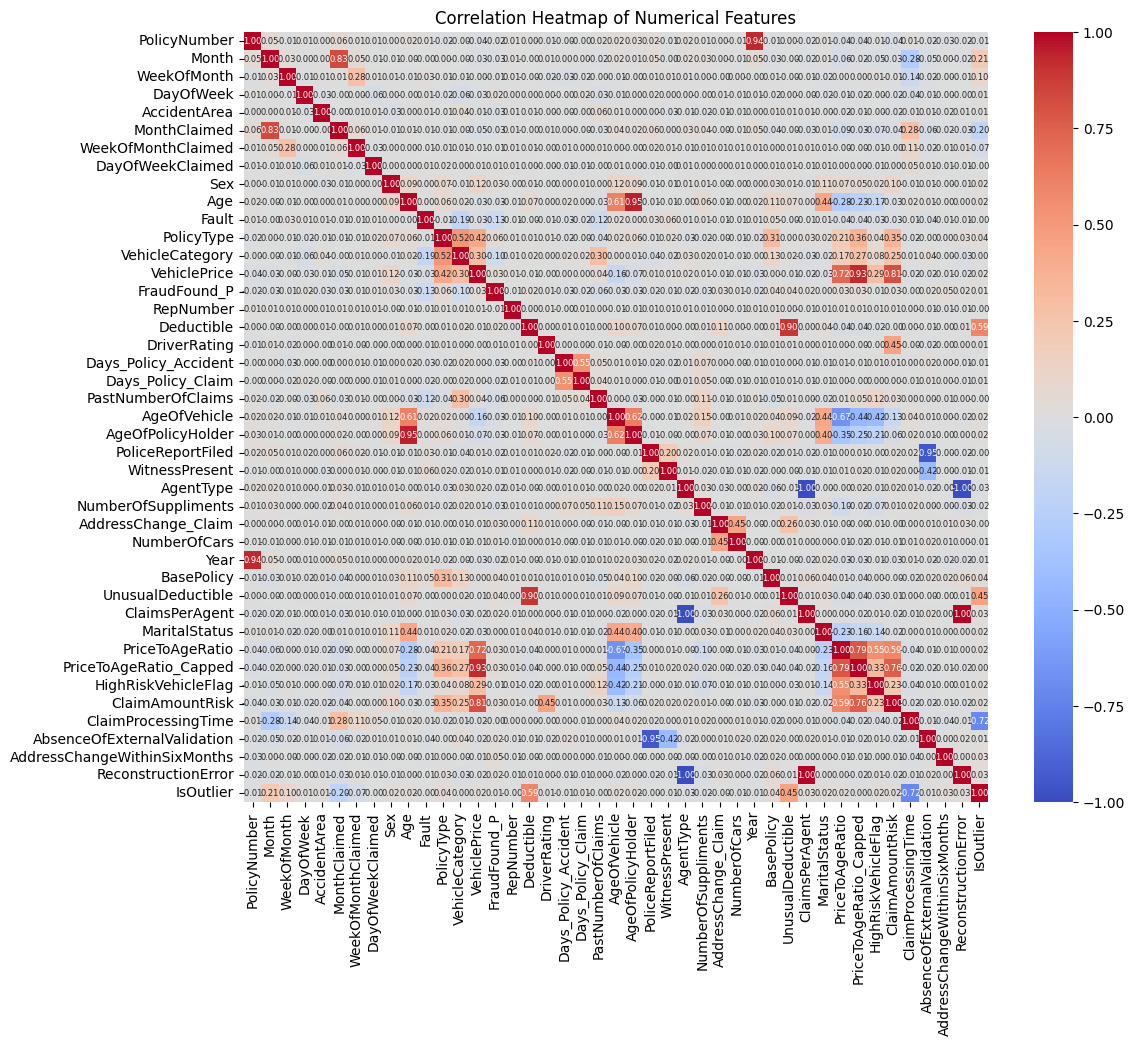

In [147]:
# Correlation heatmap
corr = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",annot_kws={"size": 6})
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig("viz/variables_corr.png", dpi=300, bbox_inches='tight')
plt.show()

# **Issue: Curse of Dimensionality**

The "curse of dimensionality" refers to the challenges that arise when working with high-dimensional data such as increased computational complexity and difficulty in visualization and interpretation.

Since our features contain both categorical and numerical data, we have applied several techniques to make the data more compatible. For numerical data which are far apart, we will normalize the data to ensure that they have similar ranges. For categorical data, we use label encoding to encode the categorical data into numerical values.

Hence, by ploting a histogram we can determine if our data is currently facing issue by examining the shape and the standard deviation of the plot.


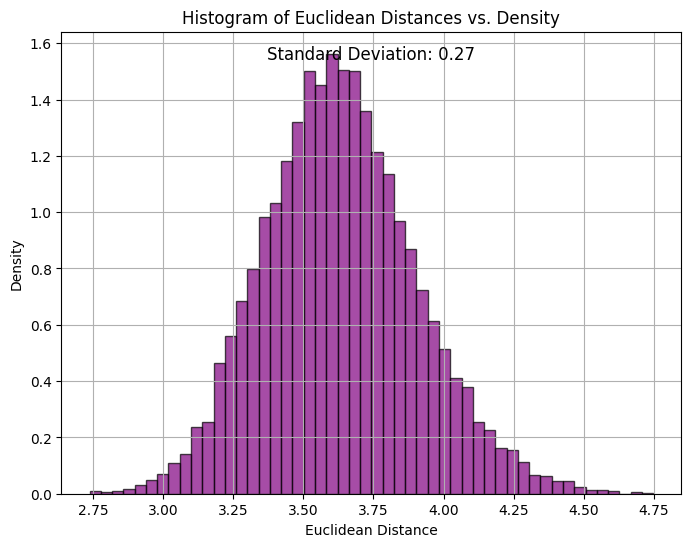

In [148]:
from sklearn.preprocessing import MinMaxScaler

# Drop the columns you don't need
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Compute Euclidean distances between samples and origin
distances = np.linalg.norm(X_normalized, axis=1)

# Calculate standard deviation of Euclidean distances
std_dev = np.std(distances)

# Plot histogram with density
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, density=True, edgecolor='black', alpha=0.7, color='purple')
plt.title('Histogram of Euclidean Distances vs. Density')
plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.grid(True)

# Add standard deviation to the plot
plt.text(0.5, 0.95, f'Standard Deviation: {std_dev:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)
plt.savefig("viz/curse_of_dimensionality_test.png", dpi=300, bbox_inches='tight')
plt.show()


The plot suggests a normally distributed curve with a rounded peak and an acceptable level of standard deviation. Thus, it appears that the features excluding FraudFound_P does not exhibit the **'Curse of Dimensionality.'** Nonetheless, we intend to proceed with feature selection as we suspect the presence of some meaningless or redundant features in the dataset.

# **Feature Selection Methods**

## Correlation Thresholding

### Remove features that are highly correlated with each other

In [149]:
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

In [150]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_reduced = X.drop(columns=to_drop)

In [154]:
X_reduced.shape

(15419, 38)

In [157]:
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    random_seed=42,
    verbose=0
)

In [158]:
rfecv = RFECV(
    estimator=catboost_model,
    step=1,
    cv=StratifiedKFold(n_splits=5), 
    scoring='roc_auc',
    n_jobs=1 
)

In [159]:
rfecv.fit(X_reduced, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=<catboost.core.CatBoostClassifier object at 0x000002A22ACCE7D0>,
      n_jobs=1, scoring='roc_auc')

In [160]:
optimal_num_features = rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

Optimal number of features: 18


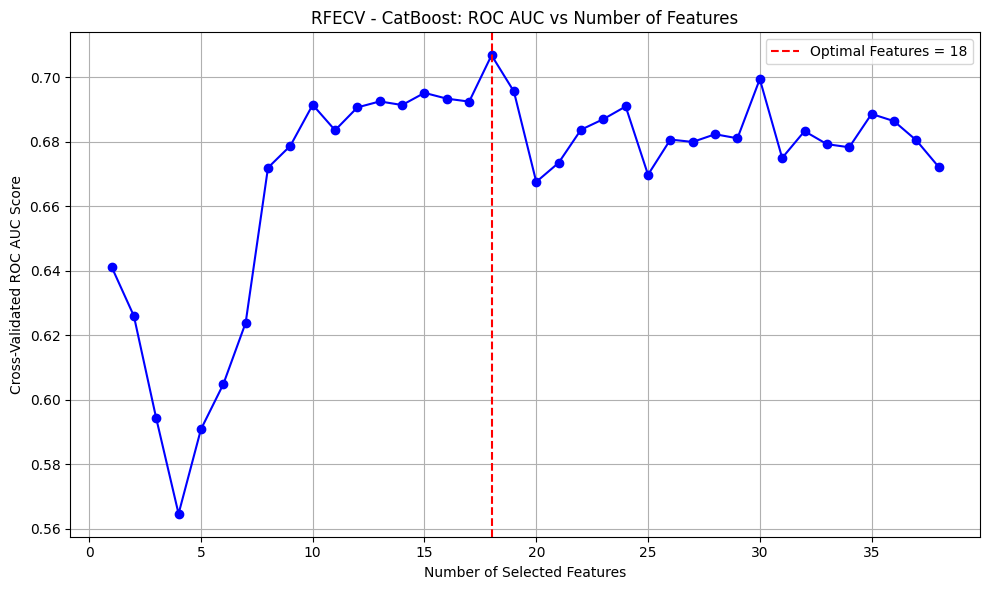

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o',
    linestyle='-',
    color='blue'
)
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validated ROC AUC Score")
plt.title("RFECV - CatBoost: ROC AUC vs Number of Features")
plt.grid(True)
plt.axvline(x=rfecv.n_features_, color='red', linestyle='--', label=f'Optimal Features = {rfecv.n_features_}')
plt.legend()
plt.tight_layout()
plt.show()

In [162]:
X_selected = rfecv.transform(X_reduced)
selected_feature_indices = np.where(rfecv.support_)[0]
selected_feature_names = X_reduced.columns[selected_feature_indices]
X_rfecv = pd.DataFrame(X_selected, columns=selected_feature_names)

In [163]:
feature_ranking = pd.Series(rfecv.ranking_, index=X_reduced.columns)
feature_ranking = feature_ranking.sort_values()
feature_ranking.head(10)

Month                     1
ClaimProcessingTime       1
PriceToAgeRatio_Capped    1
PriceToAgeRatio           1
UnusualDeductible         1
BasePolicy                1
Year                      1
AddressChange_Claim       1
NumberOfSuppliments       1
AgeOfVehicle              1
dtype: int32

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation

## Helper functions

def preprocess(S, target_col='FraudFound_P', test_size=0.3, random_state=123):
    X = S.drop(columns=[target_col])
    y = S[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def FeatureRankingrf(X, y): # Model 1: Random Forest
    """
    Rank features using feature_importances_ from Random Forest.
    Returns a list of feature names sorted from most important to least.
    """
    rf = RandomForestClassifier(random_state=123)
    rf.fit(X, y)
    importance = rf.feature_importances_
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]

def FeatureRankingxgb(X, y): # Model 2: XGBoost
    """
    Rank features using a XGBoost's coefficients.
    Returns a list of feature names sorted from most important to least.
    """
    xb = xgb.XGBClassifier(random_state=123)
    xb.fit(X, y)
    importance = xb.feature_importances_
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]
    
def FeatureRankinglr(X, y): # Model 3: Logistic Regression
    """
    Rank features using absolute coefficients from Logistic Regression.
    Returns a list of feature names sorted from most important to least.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lr = LogisticRegression(max_iter=10000, random_state=123)
    lr.fit(X_scaled, y)
    importance = np.abs(lr.coef_[0]) / np.abs(lr.coef_[0]).max()
    features = X.columns.tolist()
    ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
    return [f for f, imp in ranking]

def drop_lowest_features(X, ranking, e):

    features_to_drop = ranking[-e:] 
    return X.drop(columns=features_to_drop), features_to_drop

def Correlation(X, c):
    corr = X.corr().abs()
    # Set values below threshold c to 0 to emphasize stronger correlations
    corr_thresholded = corr.where(corr >= c, other=0)
    return corr_thresholded

def AffinityPropagationClustering(similarity_matrix, p):

    ap = AffinityPropagation(affinity='precomputed', preference=p, max_iter=500, random_state=123)
    ap.fit(similarity_matrix)
    clusters = {}
    for label, feature in zip(ap.labels_, similarity_matrix.index):
        clusters.setdefault(label, []).append(feature)
    return clusters

def get_delegates(ranking, clusters):

    delegates = []
    for cluster_features in clusters.values():
        # Choose the feature with the smallest index in the ranking (i.e., most important)
        best = min(cluster_features, key=lambda f: ranking.index(f) if f in ranking else float('inf'))
        delegates.append(best)
    return delegates


In [ ]:
def MFFS(S, e, p, c, target_col='FraudFound_P'):
    """
    Multi-Filter Feature Selection (MFFS) algorithm.
    Inputs:
      - S: DataFrame of data including features and target variable.
      - e: Number of lowest-ranked features to drop per filter (e.g., 5% of total features)
      - p: Preference parameter for Affinity Propagation (e.g., the median of similarity values)
      - c: Correlation threshold for the similarity matrix
      - target_col: Name of the target variable column.
    Outputs:
      - S_prime: DataFrame with only the selected features.
      - SF: List of selected feature names.
    """
    # Step 1: Preprocess data (split into train/test)
    xtrain, xtest, ytrain, ytest = preprocess(S, target_col=target_col)
    
    # Step 2: Get feature rankings from three filter methods
    VIlr = FeatureRankinglr(xtrain, ytrain)
    VIxgb = FeatureRankingxgb(xtrain, ytrain)
    VIrf = FeatureRankingrf(xtrain, ytrain)
    
    SF = []  
    ranking_list = [VIlr, VIxgb, VIrf]
    
    # For each filter method's ranking:
    for ranking in ranking_list:
        # Step 3: Drop the lowest e features from xtrain (for the current ranking)
        xtrain_reduced, _ = drop_lowest_features(xtrain, ranking, e)
        # Step 4: Compute the correlation similarity matrix with threshold c
        sm = Correlation(xtrain_reduced, c)
        # Step 5: Cluster the features using Affinity Propagation with preference p
        clusters = AffinityPropagationClustering(sm, p)
        # Step 6: From the ranking vector VI, select one delegate per cluster
        delegates = get_delegates(ranking, clusters)
        # Add delegates to the selected feature set (SF) if not already included
        for feat in delegates:
            if feat not in SF:
                SF.append(feat)
    
    # Subset the original xtrain and xtest to only include the selected features
    xtrain_selected = xtrain[SF]
    xtest_selected = xtest[SF]

    S_prime = pd.concat([xtrain_selected, xtest_selected], axis=0)
    
    return S_prime, SF

In [167]:
numeric_df_copy = numeric_df.drop(columns = ['PolicyNumber'])

#Values of e, p and c have been trial and tested to get the optimal output with full convergence
S_prime, selected_features = MFFS(numeric_df_copy, e=18, p=0, c=0.5, target_col='FraudFound_P')
print("Selected features:", selected_features)

Selected features: ['PoliceReportFiled', 'Fault', 'AgeOfVehicle', 'VehicleCategory', 'VehiclePrice', 'UnusualDeductible', 'AbsenceOfExternalValidation', 'Deductible', 'PolicyType', 'AgeOfPolicyHolder', 'MonthClaimed', 'WeekOfMonthClaimed', 'ReconstructionError', 'Age', 'ClaimAmountRisk', 'ClaimProcessingTime']


In [168]:
S_prime

,PoliceReportFiled,Fault,AgeOfVehicle,VehicleCategory,VehiclePrice,UnusualDeductible,AbsenceOfExternalValidation,Deductible,PolicyType,AgeOfPolicyHolder,MonthClaimed,WeekOfMonthClaimed,ReconstructionError,Age,ClaimAmountRisk,ClaimProcessingTime
6794,0,0,6,1,1,0,1,400,11,33,1,5,5892858.5,27,3,360
9946,0,0,6,1,1,0,1,400,11,33,4,1,5892609.0,34,1,419
9765,0,0,6,1,1,1,1,700,11,45,5,4,5899106.0,49,1,367
15174,0,0,6,2,1,0,1,400,12,33,11,5,5892528.5,32,1,414
6676,0,0,7,2,1,0,1,400,12,45,10,1,5892863.0,55,4,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10520,0,0,6,2,5,0,1,400,21,38,3,1,5892741.5,41,15,360
2557,0,0,5,1,1,0,1,400,11,33,8,1,5892659.5,34,1,374
381,0,1,4,2,1,0,1,400,12,33,2,4,5892763.0,35,4,374
7899,0,1,6,2,1,0,1,400,12,33,4,2,5892853.5,28,3,373


# Sampling methods

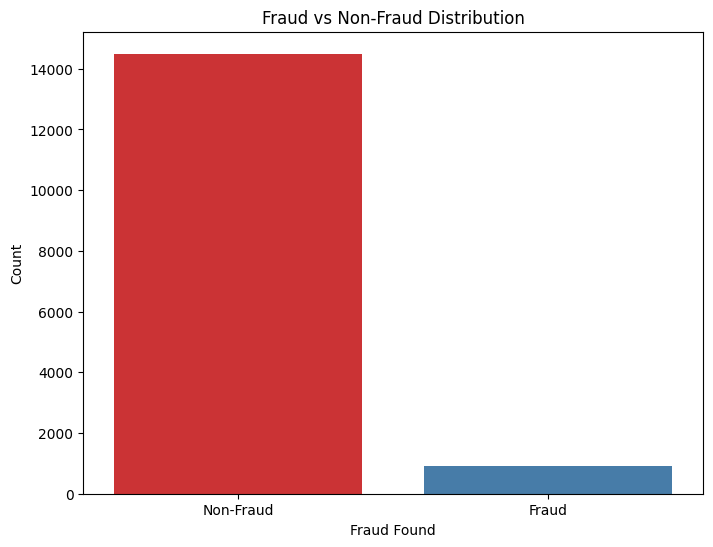

FraudFound_P
0    14496
1      923
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

In [169]:
#Overall distribution of fraudfound_p
fraud_vs_non_fraud = numeric_df['FraudFound_P'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8,6))
sns.countplot(x='FraudFound_P', data=numeric_df, palette='Set1')

# Customize the plot
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Fraud Found')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

# Show the plot
plt.show()
plt.savefig("viz/overall_fraud_dist.png", dpi=300, bbox_inches='tight')
print(fraud_vs_non_fraud)

From above, we can see that the data is very imbalanced when it comes to fraud vs non-fraud, hence calling the need for sampling methods to balance out the dataset.

### Oversampling
Use X_train_oversampled, y_train_oversampled when doing the models

In [170]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfecv, y, test_size=0.2, random_state=42)  # 80-20 split

# Define SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to oversample the minority class 
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_oversampled).value_counts().to_string())

Class distribution after oversampling:
FraudFound_P
1    11611
0    11611


In [171]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_mffs, X_test_mffs, y_train_mffs, y_test_mffs = train_test_split(S_prime, y, test_size=0.2, random_state=42)  # 80-20 split

# Define SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to oversample the minority class 
X_train_oversampled_mffs, y_train_oversampled_mffs = smote.fit_resample(X_train_mffs, y_train_mffs)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_oversampled_mffs).value_counts().to_string())

Class distribution after oversampling:
FraudFound_P
1    11611
0    11611


In [172]:
df_train = pd.concat([X_train,y_train],axis=1)
df_train_smote = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)
df_test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
df_train_mffs_smote = pd.concat([X_train_oversampled_mffs, y_train_oversampled_mffs], axis=1)
df_test_mffs = pd.concat([X_test_mffs.reset_index(drop=True),y_test_mffs.reset_index(drop=True)], axis=1)
df_train.to_csv("data/train.csv", index = False)
df_train_smote.to_csv("data/train_oversampled.csv", index=False)
df_test.to_csv("data/test.csv", index=False)
df_train_mffs_smote.to_csv("data/train_oversampled_mffs.csv", index = False)
df_test_mffs.to_csv("data/test_mffs.csv", index = False)